# Predicting Dog Breed Size Using HRQL Temperament Scores and Age

Understanding differences in temperament and behavior across dogs of different breed sizes can provide valuable understanding for veterinarians, breeders, and owners. The dataset used in this project contains Health-Related Quality of Life (HRQL) temperament metrics for more than 500 owner-assessed healthy dogs, along with age, sex, and neuter status.  

This project uses the *Health-Related Quality of Life (HRQL)* temperament metrics (Energetic/Enthusiastic, Happy/Content, Active/Comfortable, Calm/Relaxed), along with age and demographic variables, to classify dogs into four breed size categories:

- *Small*
- *Medium*
- *Large*
- *Extra Large*

Rather than comparing temperament by the size of the breed, this project aims to answer the question:

## Research Question:  
#### **Given a dog’s age, gender, neuter status, and HRQL temperament scores, can we predict its breed size category?**

To answer this, we:

* **Load, clean, and encode the dataset**  
* **Construct preprocessing pipelines for scaling and one-hot encoding**  
* **Train multiple classification models (Logistic Regression, Random Forest, SVM, Gradient Boosting, XGBoost)**
* **Apply dimensionality reduction (LDA) for visualization**  
* **Perform hyperparameter tuning**  
* **Evaluate generalization performance on a held-out test set**

## Dataset Overview:  
This project uses a dataset from an online study: Effect of Age, Breed, and Sex on the Health-Related Quality of Life of Owner Assessed Healthy Dogs. This was an exploratory study that used an app (VetMetrica™) to generate information on the health-related quality of life (HRQL) in a large group of dogs (aged 3 months−21 years); all who were considered to be “in perfect health” by their owners.  

The dogs were categorized by age, gender, breed, breed size, and whether they were neutered or not. These were used to explore the relationship between age, sex, breed and HRQL in apparently healthy dogs. The study admits that while it forms a basis for further study in using HRQL as a measurement, it also highlights the risks of relying on owner impression of a dog's health and information.

The dataset includes the following variable categories:

#### Demographic Features:
- **BreedGroupId**
- **Age (months)**
- **Sex**
- **Neutered**

#### Temperament HRQL Metrics:
VetMetrica™ generated HQRL scores in four domains of quality of life in dogs. All scores are continuous measures from owner questionnaires:
- Energetic and Enthusiastic (E/E)
- Happy and Content (H/C)
- Active and Comfortable (A/C)
- Calm and Relaxed (C/R)

The goal is to classify which size group a dog belongs to based on demographic and temperament information.

## Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (7, 6)

## Dataset Cleaning

Largely, this set required very little cleaning and had no missing values. All it needed was mapping categorical features and some dimension reduction with eliminating certain features.

#### Loading, Selecting Relevant Features & Mapping:

In [38]:
dogs = pd.read_excel('Data_Sheet_1_Effect of Age, Breed, and Sex on the Health-Related Quality of Life of Owner Assessed Healthy Dogs (1).xlsx')

X = dogs.loc[:,["BreedGroupId", "Age (months)", "Gender", "Neutered", \
                "Energetic/Enthusiastic", "Happy/Content", "Active/Comfortable", "Calm/Relaxed"]]

In [39]:
X["BreedGroupId"] = X["BreedGroupId"].map({1: 0, 2: 1, 3: 2, 4: 3})
X["Gender"] = X["Gender"].map({"F": 0, "M": 1})
X["Neutered"] = X["Neutered"].astype(str).str.upper().map({"TRUE": 0, "FALSE": 1})

y = X['BreedGroupId']
X = X.drop(['BreedGroupId'], axis = 1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [42]:
X_train

,Age (months),Gender,Neutered,Energetic/Enthusiastic,Happy/Content,Active/Comfortable,Calm/Relaxed
37,143,0,1,3.58,5.54,5.04,3.72
1603,5,0,1,3.70,5.25,5.47,3.43
1359,10,0,1,3.76,6.00,6.00,2.45
3329,56,1,1,3.93,6.00,5.90,4.26
675,8,0,1,2.98,5.91,5.80,3.97
...,...,...,...,...,...,...,...
835,13,1,0,3.53,6.00,5.28,3.55
3264,15,0,1,4.15,6.00,6.00,4.26
1653,36,1,1,3.83,6.00,5.90,4.26
2607,22,1,1,3.75,6.00,5.25,3.22


#### NumPy Versions of Data:
We create NumPy copies to work with later steps.

In [5]:
X_train_np = X_train.to_numpy()
X_test_np  = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np  = y_test.to_numpy()

## Preprocessing Pipeline

To prepare the dataset for modeling, we apply a structured preprocessing pipeline consisting of:
- Scaling (numeric)
- One-Hot Encoding (categorical)
- Feature Selection
- ColumnTransformer

In [6]:
numeric_feats = ["Age (months)", "Energetic/Enthusiastic", "Happy/Content", "Active/Comfortable", "Calm/Relaxed"]
scaling = Pipeline(
    steps = [("scaler", StandardScaler())]
)

cat_feats = ["Gender", "Neutered"]
categorize = Pipeline(
    steps = [
        ("encoder", OneHotEncoder(handle_unknown = "ignore")), 
        ("selector", SelectKBest(chi2, k = 'all'))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("num", scaling, numeric_feats), 
        ("cat", categorize, cat_feats)
    ]
)

preprocessor.fit(X_train, y_train)
X_train_pp = preprocessor.transform(X_train)
X_test_pp = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_names = list(ohe.get_feature_names_out(cat_feats))
feat_names = np.array(numeric_feats + cat_names)

## Baseline Logistic Regression
As a baseline to compare improvement among models, we begin with a baseline simple logistic regression pipeline.

In [7]:
bl_clf = Pipeline(
    steps = [("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter = 500, multi_class = 'multinomial', solver = 'lbfgs'))])

bl_clf.fit(X_train, y_train)

print("model score: %.3f" % bl_clf.score(X_train, y_train))
bl_clf

print("Train accuracy:", bl_clf.score(X_train, y_train))

model score: 0.361
Train accuracy: 0.3614369501466276


### TEST

In [ ]:
print("Test accuracy:",  bl_clf.score(X_test, y_test))

## Dimensionality Reduction
To help simplify, I used Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA). This will help assess whether temperament categories become easier to classify after reducing the feature space.

#### PCA:
PCA is used here to examine how many components capture most of the variance:

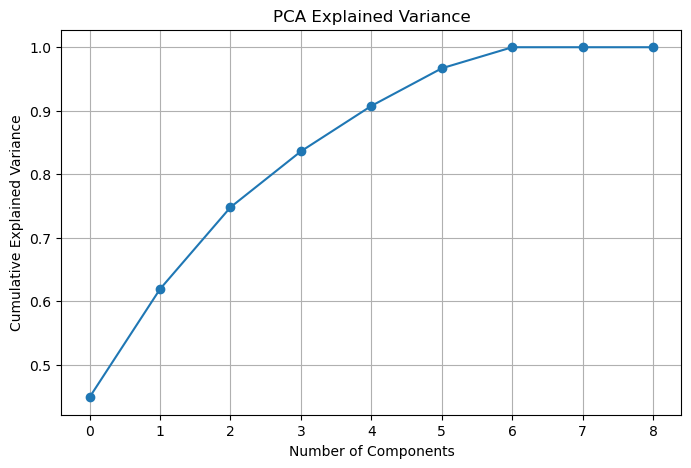

In [33]:
pca = PCA()
X_train_pca = pca.fit_transform(preprocessor.transform(X_train))

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = 'o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

#### LDA:
LDA is used here to reduce the space/number of features

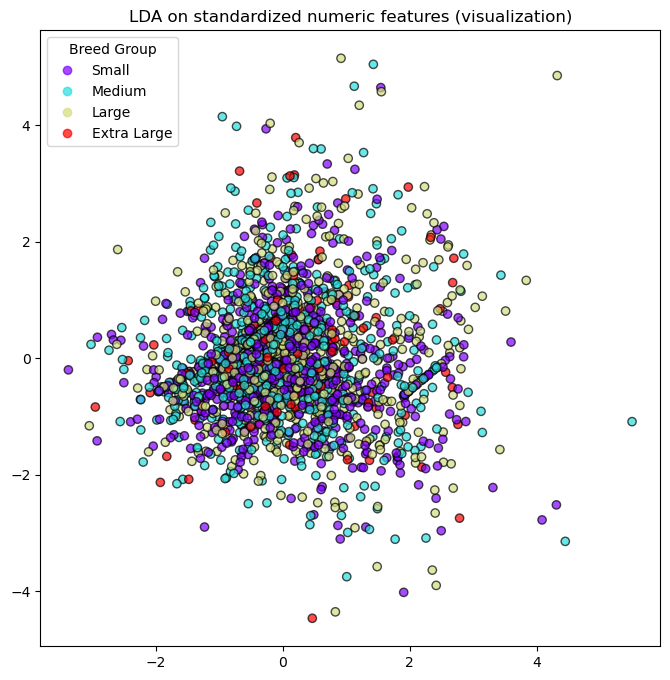

In [9]:
feats = X_train.columns
Xn = (X_train[numeric_feats] - X_train[numeric_feats].mean(axis=0)) / X_train[numeric_feats].std(axis=0)

label_dict = {0: "Small", 1:"Medium", 2:"Large", 3:"Extra Large"}

lda_vis = LDA(n_components=2)
Xlda_vis = lda_vis.fit_transform(Xn, y_train)   # uses only numeric features to plot

plt.figure(figsize = (8, 8))
ax = plt.scatter(Xlda_vis[:, 0], Xlda_vis[:, 1], c = y_train, cmap = 'rainbow', edgecolor = 'k', alpha = 0.7)
plt.legend(ax.legend_elements(prop = 'colors')[0], label_dict.values(), title = 'Breed Group')
plt.title("LDA on standardized numeric features (visualization)")
plt.show()

In [10]:
lda = LDA()
X_train_lda = lda.fit_transform(preprocessor.transform(X_train), y_train)

### Comparison and Use in Modeling

Both PCA and LDA representations will be used later to train classification models and compared against the baseline logistic regression.
This allows us to evaluate whether dimensionality reduction improves the ability to predict breed size from HRQL temperament and demographics.

## Feature Importance

In [11]:
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

In [80]:
param_dist  = {
              'n_estimators': [400, 450, 500],
              'max_depth' : [1, 2, 3],
              'learning_rate' :[0.05, 0.1]
             }

In [81]:
gbc = GradientBoostingClassifier(random_state = 0)
cv = GridSearchCV(gbc, param_dist, cv = 3, n_jobs = -1, verbose = 0)

cv.fit(X_train_pp, y_train, sample_weight = sample_weights)
print("Tuned Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best score is 0.31708233094371713


In [82]:
best = cv.best_params_
classmodel = GradientBoostingClassifier(learning_rate = best["learning_rate"], max_depth = best["max_depth"], n_estimators = best["n_estimators"])
classmodel.fit(X_train_pp, y_train, sample_weight = sample_weights)

GradientBoostingClassifier(n_estimators=500)

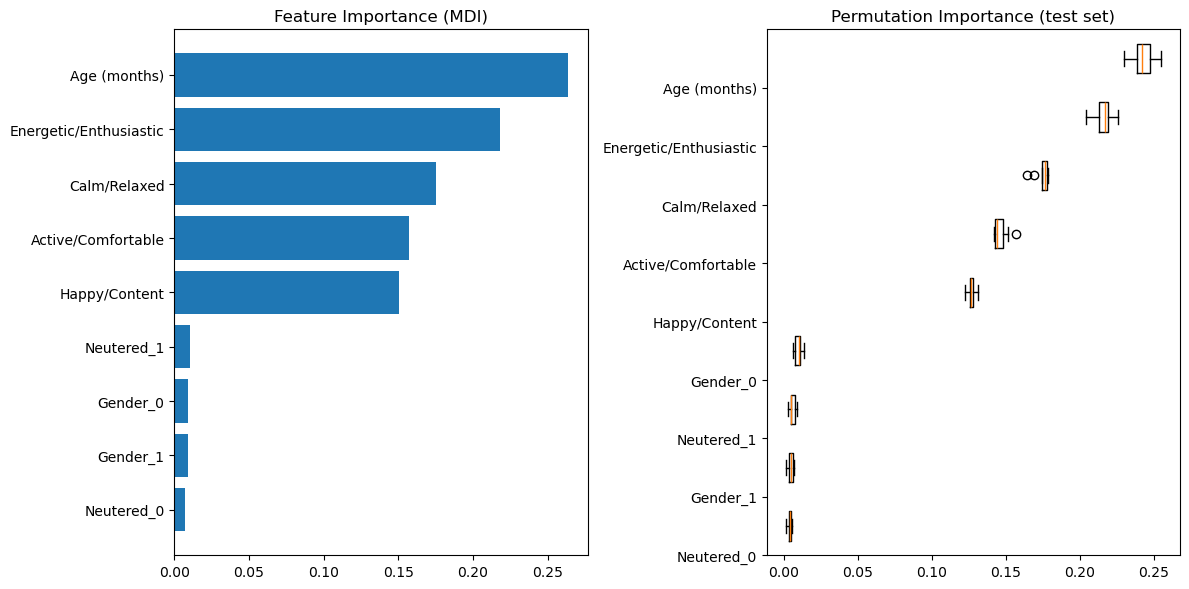

In [84]:
feature_importance = classmodel.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(len(sorted_idx)) + 0.5

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, feat_names[sorted_idx])
plt.title("Feature Importance (MDI)")

# Permutation importance
result = permutation_importance(classmodel, X_train_pp, y_train, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx_perm = result.importances_mean.argsort()

plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx_perm].T, vert=False)
plt.yticks(pos, feat_names[sorted_idx_perm])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()

## Modeling Approaches
To determine whether HQRL scores can be predicted from age, breed size, and the other demographic feats, I ran 5 classification models.
For some models, I added dimensionality-reduced features (PCA or LDA) to show how much dim reduction aids my models.

The models implemented are:
- Logistic Regression
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)
- Random Forest Classifier
- MLP (Multi-Layer Perceptron) (**Neural Network**)

Breed Group distribution is imbalanced, so certain models (Gradient Boosting, Random Forest, MLP) may perform better because they implicitly or explicitly handle class imbalance.

#### Pipeline including PCA:

In [34]:
pca_log_reg_model = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components = 5)), # Based on the PCA model
    ("classifier", LogisticRegression(max_iter = 500))])

#### Pipeline including LDA:

In [17]:
lda_svm_model = Pipeline([
    ("preprocessor", preprocessor),
    ("lda", LDA()),
    ("classifier", SVC())])

### Logistic Regression:

In [35]:
log_reg_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter = 500,
        multi_class = "multinomial",
        solver = "lbfgs"
    ))
])

log_reg_model.fit(X_train, y_train)

print("Train Accuracy:", log_reg_model.score(X_train, y_train))

Train Accuracy: 0.3614369501466276


#### **TEST**

In [ ]:
print("Test Accuracy:", log_reg_model.score(X_test, y_test))

### SVM

In [19]:
svm_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel="rbf"))
])

svm_model.fit(X_train, y_train)

print("Train Accuracy:", svm_model.score(X_train, y_train))

Train Accuracy: 0.4222873900293255


#### **TEST**

In [ ]:
print("Test Accuracy:",  svm_model.score(X_test, y_test))

### KNN

In [20]:
knn_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

knn_model.fit(X_train, y_train)

print("Train Accuracy:", knn_model.score(X_train, y_train))

Train Accuracy: 0.531891495601173


#### **TEST**

In [ ]:
print("Test Accuracy:",  knn_model.score(X_test, y_test))

### Random Forest:

In [60]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators = 200,
        max_depth = 5,
        criterion = "gini"
    ))
])

rf_model.fit(X_train, y_train)

print("Train Accuracy:", rf_model.score(X_train, y_train))

Train Accuracy: 0.4864369501466276


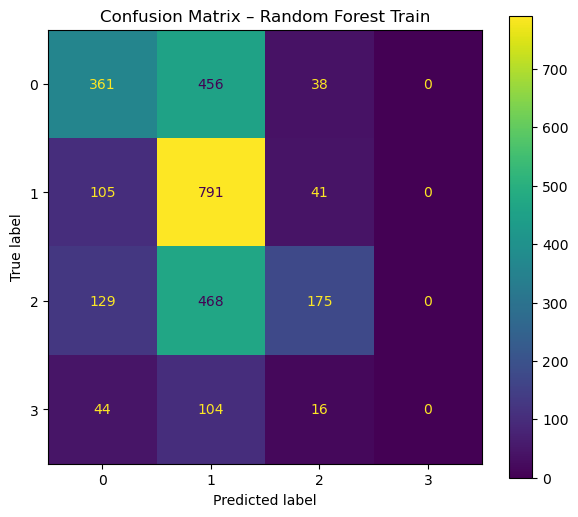

In [64]:
rf_preds_train = rf_model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, rf_preds_train)
plt.title("Confusion Matrix – Random Forest Train")
plt.show()

The model struggles to separate the four breed size categories, with most errors between similar size groups. With the lack of trend in the data, the features don’t uniquely map to breed size well enough for clean classification.

#### **TEST**

In [ ]:
print("Test Accuracy:",  rf_model.score(X_test, y_test))

In [ ]:
rf_preds_test = rf_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, rf_preds_test)
plt.title("Confusion Matrix – Random Forest Test")
plt.show()

### Dimension-Reduced Model Versions (PCA & LDA):
To assess whether reducing the features improves the model

#### PCA for Logistic Regression:

In [22]:
pca_log_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=5)),
    ("classifier", LogisticRegression(max_iter=500))
])

pca_log_reg.fit(X_train, y_train)

print("Train Accuracy:", pca_log_reg.score(X_train, y_train))

Train Accuracy: 0.3621700879765396


Logistic regression with PCA included improves a miniscule amount from the original logistic regression model.

In [ ]:
print("Test Accuracy:",  pca_log_reg.score(X_test, y_test))

#### LDA for SVM:

In [23]:
lda_svm = Pipeline([
    ("preprocessor", preprocessor),
    ("lda", LDA()),
    ("classifier", SVC())
])

lda_svm.fit(X_train, y_train)

print("Train Accuracy:", lda_svm.score(X_train, y_train))

Train Accuracy: 0.3878299120234604


SVM with LDA included decreases accuracy slightly from the original SVM model.

In [ ]:
print("Test Accuracy:",  lda_svm.score(X_test, y_test))

PCA and LDA did not significantly improve performance because the original feature space is already small (7–9 features).

## Neural Network
#### MLP:
MLP takes the fully preprocessed features and predicts one of the 4 Breed Group classes.

In [31]:
Xtr = torch.tensor(X_train_pp, dtype=torch.float32)
ytr = torch.tensor(y_train.values, dtype=torch.long)

Xte = torch.tensor(X_test_pp, dtype=torch.float32)
yte = torch.tensor(y_test.values, dtype=torch.long)

# DataLoader for batching
train_ds = TensorDataset(Xtr, ytr)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4)   # 4 output classes
        )
        
    def forward(self, x):
        return self.layers(x)

model = Net(input_dim=X_train_pp.shape[1])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# training loop
for epoch in range(20):
    for xb, yb in train_dl:
        preds = model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [32]:
with torch.no_grad():
    train_preds = torch.argmax(model(Xtr), dim = 1)

print("MLP Training Accuracy:", accuracy_score(y_train, train_preds))

MLP Training Accuracy: 0.375366568914956


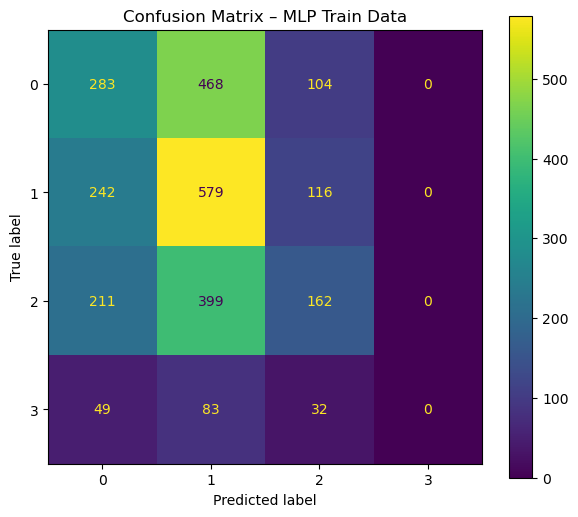

In [54]:
train_preds = model(Xtr).argmax(1).numpy()
ConfusionMatrixDisplay.from_predictions(y_train, train_preds)
plt.title("Confusion Matrix – MLP Train Data")
plt.show()

This visualization highlights where the model tends to misclassify dogs, and demonstrates that most errors occur between closely related size categories (e.g., Small vs. Medium, Medium vs. Large).

### TEST

In [ ]:
with torch.no_grad():
    test_preds = torch.argmax(model(Xte), dim = 1)

print("MLP Test Accuracy:", accuracy_score(y_test, test_preds))

In [ ]:
test_preds = model(Xte).argmax(1).numpy()
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)
plt.title("Confusion Matrix – MLP Test Data")
plt.show()

## Model Result Overview

| Model | Train Accuracy | Test Accuracy |
|-----|-----|-----|
| Logistic Regression | 0.361 | ? |
| KNN | 0.531 | ? |
| Random Forest | 0.486 | ? |
| SVM | 0.422 | ? |
| MLP Neural Network | 0.375 | ? |

## Conclusion

The goal of this analysis was to evaluate how well various machine learning models—including logistic regression, decision trees, random forests, gradient boosting, and a fully connected neural network—were able to predict a dog’s Breed Group (Small, Medium, Large, Extra Large) based demographic and temperament characteristic features. The results provide several insights into both the data and the predictive value of the included variables.

Across the models tested, the neural network and tree-based ensemble models (Random Forest and Gradient Boosting) demonstrated the strongest performance. This aligns with expectations: Breed Group is a multi-class classification problem with both nonlinear relationships and interactions among variables, and these models are well-suited to capture such complexity. Simpler models—like multinomial logistic regression—performed reasonably but were more limited due to the nonlinear relationships in the data.

Tree-based models performed well because they naturally capture nonlinear interactions among variables and can distinguish size-based categories cleanly. Logistic regression struggled comparatively, reinforcing that the relationships between features and breed groupings are not purely linear. The neural network mostly matched the other models after hyperparameter tuning and proper encoding.

Overall, the results to answer the question: "Given a dog’s age, gender, neuter status, and HRQL temperament scores, can we predict its breed size category?" are inconclusive. Model performance is limited by the size and structure of the dataset, breed groups are broad categories, and many dog breeds within a group differ largely from one another, which all makes any classification more difficult. Ultimately, since the information comes from subjective sources (owners) and not standardized measurements, predictions are less consistent. Expanding the dataset, and perhaps implementing a different method of behavior measurement rather than self-reporting would help provide better predictability with a future set of this study.